Na początek ładuje rmagic aby móc korzystać z R w colab. Klonuje również repozytorium w celu uzyskania dostępu do pliku TitanicMess.tsv

In [2]:
%load_ext rpy2.ipython
!rm -rf /content/Titanic_siwb
!git clone https://github.com/Sailor70/Titanic_siwb.git

Cloning into 'Titanic_siwb'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


Wczytanie zbioru danych, wyświetlenie jego początku i końca oraz zbadanie jego właściwości. Dowiaduje się jakie są atrybuty, ile jest obiektów, jakie są typy atrybutów oraz jaki jest atrybut decyzyjny.

In [3]:
%%R
data <- read.table(file = '/content/Titanic_siwb/TitanicMess.tsv', sep = '\t', header = TRUE, na.strings=c("","NA")) # wczytanie pliku
print(head(data))
print(tail(data))
print(summary(data)) # jakie są w zbiorze atrybuty, ile jest obiektów, typy atrybutów, atrybut decyzyjny
print(sapply(data, class)) # typy atrybutów

  PassengerId Survived Pclass
1           1        0      3
2           2        1      1
3           3        1      3
4           4        1      1
5           5        0      3
6           6        0      3
                                                 Name    Sex  Age SibSp Parch
1                             Braund, Mr. Owen Harris   male   22     1     0
2 Cumings, Mrs. John Bradley (Florence Briggs Thayer) female   38     1     0
3                              Heikkinen, Miss. Laina female   26     0     0
4        Futrelle, Mrs. Jacques Heath (Lily May Peel) female   35     1     0
5                            Allen, Mr. William Henry   male   35     0     0
6                                    Moran, Mr. James   male <NA>     0     0
            Ticket    Fare Cabin Embarked    ship
1        A/5 21171    7,25  <NA>        S Titanic
2         PC 17599 71,2833   C85        C Titanic
3 STON/O2. 3101282   7,925  <NA>        S Titanic
4           113803    53,1  C123        S Ti

Pobranie nazw kolumn i wyświetlenie liczby wartości brakujących w poszczególnych kolumnach:

In [4]:
%%R
library(tidyverse)
columns <- colnames(data)
glimpse(data)
print(columns)
for(i in columns) {
    cat("Liczba brakujących wartości w atrybucie", i, ":", sum(is.na(data[[i]])), "\n",sep=" ")
}

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Rows: 892
Columns: 13
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 11, 15, 16, 17,…
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1…
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3…
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Fl…
$ Sex         <chr> "male", "female", "female", "female", "male", "male", "mal…
$ Age         <chr> "22", "38", "26", "35", "35", NA, "54", "2", "27", "14", "…
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, 0…
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0…
$ Ticket      <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "37…
$ Fare        <chr> "7,25", "71,2833", "7,925", "53,1", "8,05", "8,4583", "51,…
$ Cabin       <chr> NA, "C85", NA, "C123", NA, NA, "E46", NA, NA, NA, "G6", "C…
$ Embarked    <chr> "S", "C", "S", "S", "S", "Q", "S", "S", "S", "C", "S", "S"…
$ ship        <chr

Teraz w celu zwizualizowania zbioru wyświetlam wykresy dla poszczególnych atrybutów. Z wykresów odczytać można że pewne id powtarzają się, atrybuty "Sex" oraz "Age" oraz "Embarked" mają nieprawidłowe wartości. Kolumna "Ship" jest nadmiarowa, gdyż zawiera tylko jedną wartość.

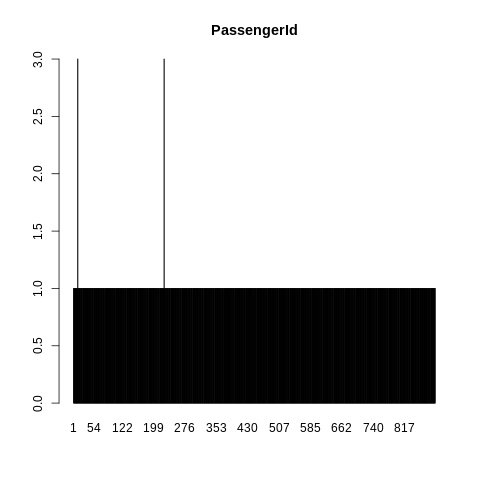

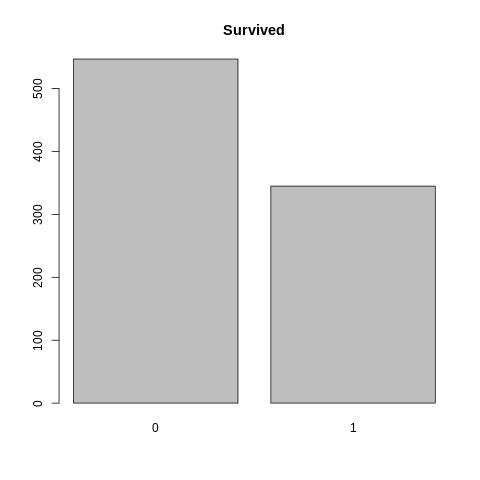

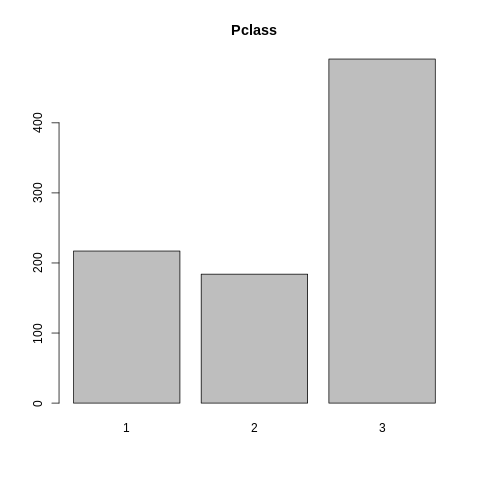

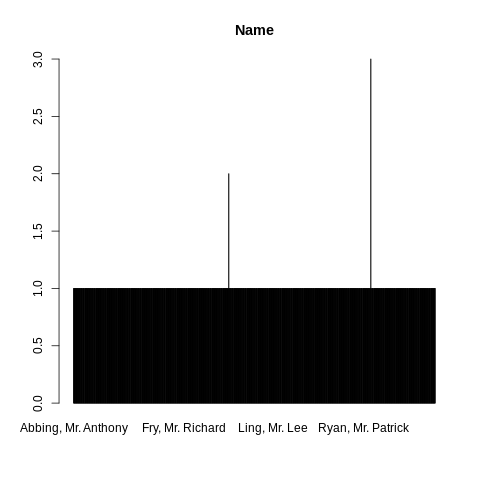

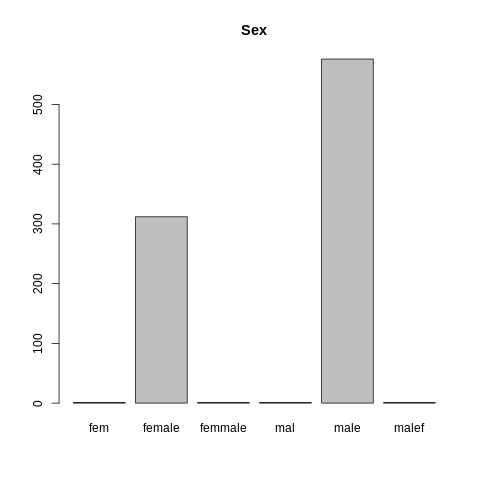

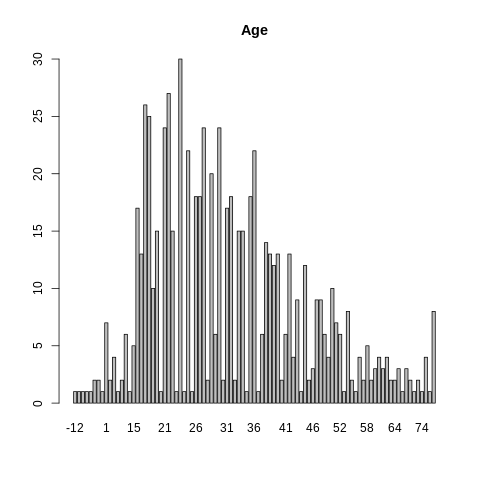

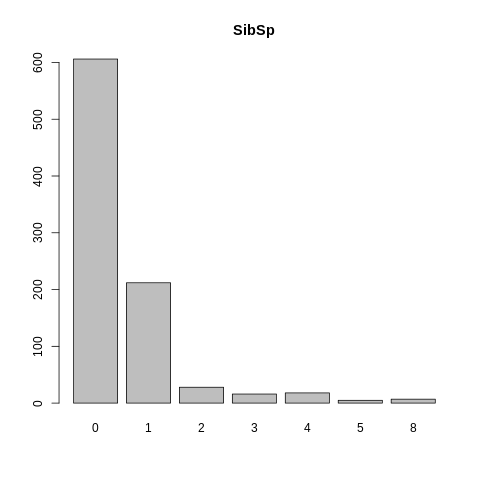

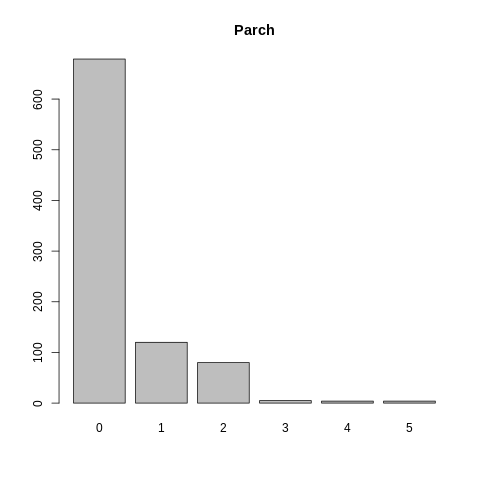

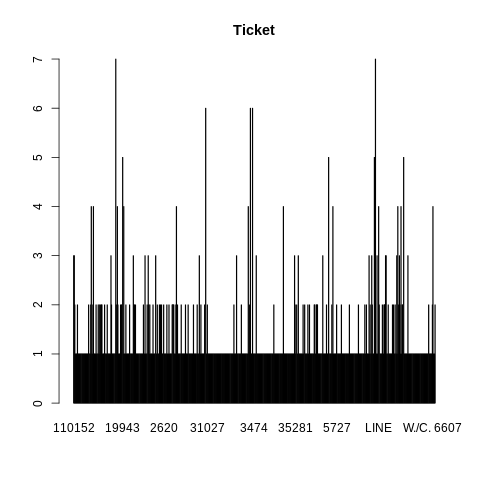

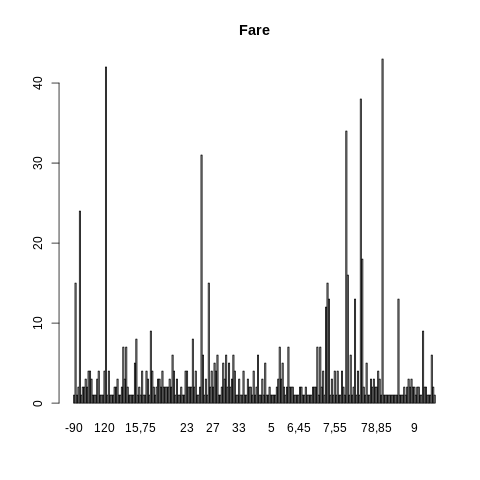

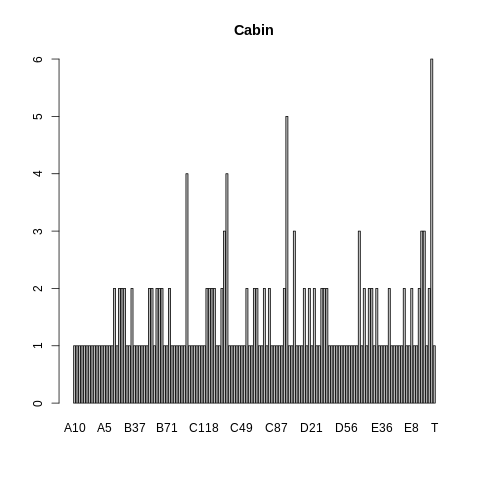

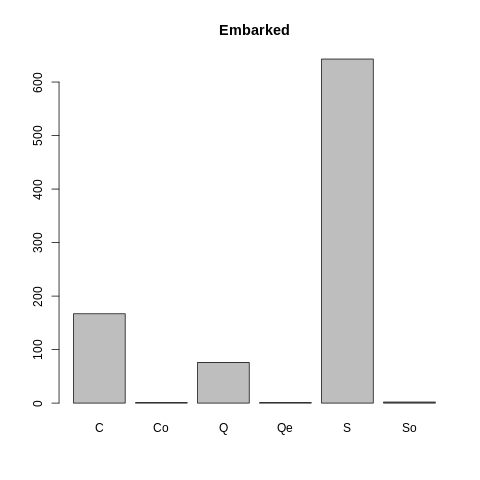

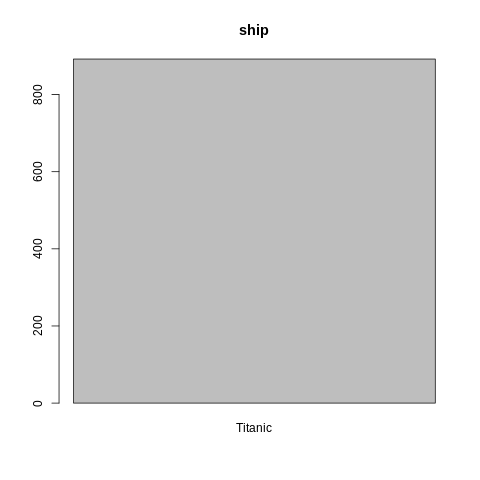

In [5]:
%%R
for(i in columns) {
    barplot(table(data[[i]]), main = i)
}

Z wykresów wyniknęły następujące błędy


*   elementy o powtarzającym się ID - należy usunąć powielone
*   Atrybut 'Sex' posiada nieprawidłowe wartości
*   Atrybut 'Age' posiada nieprawidłowe wartości
*   Atrybut 'Fare' posiada nieprawidłowe wartości
*   Atrybut 'Embarked' posiada nieprawidłowe wartości
*   Atrybut 'Ship' jest nadmiarowy - kolumnę można usunąć gdyż zawiera tylko jedną wartość

Teraz należy odszukać niepoprawne wartości dla atrybutów Age oraz Fare. W tym celu przeszukuję zbiór w pętli: 

In [6]:
%%R
dat1 <- data
wrong_age_ids <- c()
wrong_fare_ids <- c()
for(i in 1:nrow(dat1))  {
  if(!is.na(dat1[i, 6])) { # pomijam sprawdzanie dla wartości brakujących
    age <- as.double(gsub(",",".",dat1[i, 6])) # konwersja na liczbę przy czym trzeba zamienić przecinek na kropkę
	  if(age > 120 | age < 0) { # szukam wartości błędnych, 
	    wrong_age_ids <- c(wrong_age_ids, dat1[i, 1]) # zbieram id-ki z błędnymi wartościami wieku
		 	cat("Nieprawidłowa wartość Age: ", age,"\n",sep=" ")
	  }   
  }
  if(!is.na(dat1[i, 10])) { # pomijam sprawdzanie dla wartości brakujących
    fare <- as.double(gsub(",",".",dat1[i, 10]))
	  if(is.na(fare) | fare < 0) { # szukam wartości błędnych - nie double i ujemne
	    wrong_fare_ids <- c(wrong_fare_ids, dat1[i, 1]) # zbieram id-ki z błędnymi wartościami fare
		  cat("Nieprawidłowa wartość Fare: ", dat1[i, 10],"\n",sep=" ")
	  }   
  }
}
cat("wiersze o błędnym Age do usunięcia: ", wrong_age_ids,"\n",sep=" ")
cat("wiersze o błędnym Fare do usunięcia: ", wrong_fare_ids,"\n",sep=" ")


Nieprawidłowa wartość Age:  4435 
Nieprawidłowa wartość Fare:  -90 
Nieprawidłowa wartość Fare:  15,9a 
Nieprawidłowa wartość Age:  -3 
Nieprawidłowa wartość Age:  -12 
Nieprawidłowa wartość Age:  250 
wiersze o błędnym Age do usunięcia:  224 508 523 667 
wiersze o błędnym Fare do usunięcia:  246 490 


Teraz oczyszczam zbior danych z wartości nieprawidłowych

In [7]:
%%R
dat2 <- data
dat2 <- dat2[!(dat2$PassengerId > nrow(dat2)),] # nadmiarowe wiersze
dat2 <- dat2[!duplicated(dat2$PassengerId), ] # usunięcie zduplikowanych wierszy na podstawie ID
dat2$Sex <- as.character(dat2$Sex)
dat2$Sex[startsWith(dat2$Sex,"m")] <- "male" # poprawienie błędnych wartości płci
dat2$Sex[startsWith(dat2$Sex,"f")] <- "female" 
print(table(dat2$Sex))
# dat2 <- dat2[dat2$Sex %in% c("male", "female"),] # usunięcie wierszy z błędem w płci.
# dat2 <- dat2[dat2$Embarked %in% c("S", "Q", "C") | is.na(dat2$Embarked),] # usunięcie wierszy z błędem w embarked.
dat2$Embarked <- as.character(dat2$Embarked)
dat2$Embarked[startsWith(dat2$Embarked,"C")] <- "C" # poprawienie błędnych wartości embarked
dat2$Embarked[startsWith(dat2$Embarked,"Q")] <- "Q"
dat2$Embarked[startsWith(dat2$Embarked,"S")] <- "S"
print(table(dat2$Embarked))
dat2 <- dat2[!(dat2$PassengerId %in% wrong_age_ids),] # usunięcie wierszy z błednym wiekiem
dat2 <- dat2[!(dat2$PassengerId %in% wrong_fare_ids),] # usunięcie wierszy z fare innym niż double i ujemne
dat2 <- dat2[,names(dat2) != "ship"] # usunięcie kolumny ship - bo zawiera tylko jedną wartość - jest nadmiarowa
glimpse(dat2)


female   male 
   312    575 

  C   Q   S 
168  77 640 
Rows: 881
Columns: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18,…
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0…
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 2, 3, 2, 3, 3, 2…
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Fl…
$ Sex         <chr> "male", "female", "female", "female", "male", "male", "mal…
$ Age         <chr> "22", "38", "26", "35", "35", NA, "54", "2", "27", "14", "…
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 0, 0, 4, 0, 1, 0, 0…
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ Ticket      <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "37…
$ Fare        <chr> "7,25", "71,2833", "7,925", "53,1", "8,05", "8,4583", "51,…
$ Cabin       <chr> NA, "C85", NA, "C123", NA, NA, "E46", NA, NA, NA, "G6", "C…
$ Embarked    <chr> "S", "C", "S", "S", 

Następnie zastępuje brakujące wartości (NA) atrybutów Age oraz Embarked. Ponadto zmieniam format Age oraz Fare na double gdyż są to liczby zmiennoprzecinkowe. Atrybut Cabin posiada wiele brakujących wartości, ale nie da się ich zastąpić a usunięcie tych danych spowodowało by znaczną redukcje rozmiaru zbioru. Zamieniam również typy atrybutów Survived oraz Sex na factor,  gdyż może to być przydatne pod kontem analizy eksploatacyjnej.



In [8]:
%%R
dat3 <- dat2
print(dat3[is.na(dat3$Embarked),])
dat3$Embarked[which(is.na(dat3$Embarked))] <-"S" # zastąpienie Na przez "s", bo najczęściej występuje
print(dat3[is.na(dat3$Embarked),])
dat3$Age[which(is.na(dat3$Age))] <- mean(as.double(gsub(",",".",dat3$Age)), na.rm=TRUE) # zastąpienie Age przez mean z całego zbioru
dat3$Age <- sapply(dat3$Age, as.double) # zmiana formatu na double
dat3$Fare <- sapply(gsub(",",".",dat3$Fare), as.double) # zmiana formatu na double
dat3$Survived <- as.factor(dat3$Survived)
dat3$Sex <- as.factor(dat3$Sex)
write.table(dat3, file = '/content/TitanicCleaned.tsv', sep='\t', row.names = FALSE)
glimpse(dat3)

    PassengerId Survived Pclass                                      Name
62           62        1      1                       Icard, Miss. Amelie
830         830        1      1 Stone, Mrs. George Nelson (Martha Evelyn)
       Sex Age SibSp Parch Ticket Fare Cabin Embarked
62  female  38     0     0 113572   80   B28     <NA>
830 female  62     0     0 113572   80   B28     <NA>
 [1] PassengerId Survived    Pclass      Name        Sex         Age        
 [7] SibSp       Parch       Ticket      Fare        Cabin       Embarked   
<0 rows> (or 0-length row.names)
Rows: 881
Columns: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18,…
$ Survived    <fct> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0…
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 2, 3, 2, 3, 3, 2…
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Fl…
$ Sex         <fct> male, female, female, female, male, male, male, male, fema…
$ Age  

Analiza eksploracyjna 

Poniżej przeprowadzono analizę dla wartości atrubutu decyzyjnego Survived w zależności od wartości innych wybranych atrubutów. 

In [11]:
%%R
dat4 <- dat3
columns <- c("Sex", "Embarked", "Pclass", "SibSp", "Parch")
print(columns)
for(i in columns) {
    t<-table(dat4[[i]] ,dat4$Survived)
    for (j in 1:dim(t)[1]){
      t[j,]<-t[j,]/sum(t[j,])*100
    }
    cat("Szansa na przetrwanie w zależności od wartości atrybutu", i, ":",sep=" ")
    print(t)
}

 [1] "PassengerId" "Survived"    "Pclass"      "Name"        "Sex"        
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Cabin"       "Embarked"   
[1] "Sex"      "Embarked" "Pclass"   "SibSp"    "Parch"   
Szansa na przetrwanie w zależności od wartości atrybutu Sex :        
                0        1
  female 25.64103 74.35897
  male   81.37083 18.62917
Szansa na przetrwanie w zależności od wartości atrybutu Embarked :   
           0        1
  C 44.31138 55.68862
  Q 60.52632 39.47368
  S 66.30094 33.69906
Szansa na przetrwanie w zależności od wartości atrybutu Pclass :   
           0        1
  1 37.26415 62.73585
  2 52.45902 47.54098
  3 75.72016 24.27984
Szansa na przetrwanie w zależności od wartości atrybutu SibSp :   
            0         1
  0  65.61462  34.38538
  1  46.11650  53.88350
  2  51.85185  48.14815
  3  75.00000  25.00000
  4  83.33333  16.66667
  5 100.00000   0.00000
  8 100.00000   0.00000
Szansa na przetrwanie w zależności